In [1]:
exp_name = "fashion-mnist"

In [2]:
import numpy as np   
import pandas as pd  
from matplotlib import pyplot as plt 

In [3]:
df_train = pd.read_csv(r'data/fashion-mnist_train.csv', dtype=int) # read train data
df_test = pd.read_csv(r'data/fashion-mnist_test.csv', dtype=int) # read test data


In [4]:
print(f"shape of train data:{df_train.shape}")
print(f"shape of test data:{df_test.shape}")
print(f"columns of data:{df_train.columns}")

shape of train data:(60000, 785)
shape of test data:(10000, 785)
columns of data:Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)


In [5]:
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']
X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

In [6]:
print(X_test)
print(y_test.unique())

      pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0          0       0       0       0       0       0       0       9       8   
1          0       0       0       0       0       0       0       0       0   
2          0       0       0       0       0       0      14      53      99   
3          0       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
9995       0       0       0       0       0       0       0       0       0   
9996       0       0       0       0       0       0       0       0       0   
9997       0       0       0       0       0       0       0       0       0   
9998       0       1       3       0       0       0       0       0       0   
9999       0       0       0       0       0       0       0     140     119   

      pixel10  ...  pixel775  pixel776 

1st approach : RandomForest and Multi layer perceptron from Sklearn

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [8]:

def train(params):
    if params["model_name"] == "RandomForest":
        model = RandomForestClassifier(n_estimators = params["n_estimators"], max_depth = params["max_depth"], random_state = 100)
    elif params["model_name"] == "MLP":
        model = MLPClassifier(
            hidden_layer_sizes=(10,),
            max_iter=params["epoch"],
            alpha=params["alpha"],
            learning_rate=params["learning_rate"],
            solver=params["optimizer"],
            batch_size=params["batch_size"],
            verbose=10,
            random_state=100
        )
    model.fit(X_train, y_train)
    return model

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
def eval_metrics(Y_test, Y_hat):
    precision = precision_score(Y_test, Y_hat, average="weighted")
    recall = recall_score(Y_test, Y_hat, average="weighted")
    f1 = f1_score(Y_test, Y_hat, average="weighted")
    metrics = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    return metrics

def create_roc_auc_plot(clf, X_data, y_data, filename):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    metrics.plot_roc_curve(clf, X_data, y_data) 
    plt.savefig(filename)
    
def create_confusion_matrix_plot(clf, X_test, y_test, filename):
    import matplotlib.pyplot as plt
    from sklearn.metrics import plot_confusion_matrix
    plot_confusion_matrix(clf, X_test, y_test)
    plt.savefig(filename)

MLFlow Runs

In [10]:
import mlflow
from mlflow.models import infer_signature


In [11]:
from urllib.parse import urlparse
def create_mlflow_runs(run_name, params, metrics, artifact_dict, model, model_name, model_signature):
    
    with mlflow.start_run(run_name=run_name):    
        # log params
        mlflow.log_params(params)
        
        # log metrics
        mlflow.log_metrics(metrics)
        
        # log artifacts
        for artifact_name, artifact_name in artifact_dict.items():
            mlflow.log_artifact(artifact_name, artifact_name)
        
        # log model
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            # Register the model
            mlflow.sklearn.log_model(
                model, "model", registered_model_name=model_name)
        else:
            # just log the model for tracking
            mlflow.sklearn.log_model(model, "model")

first experiment

In [12]:

"""
start mlflow tracking server backed by sqlite:  
mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000
"""
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment(experiment_name=exp_name)
import os
os.makedirs("temp", exist_ok=True)

2023/09/01 12:07:23 INFO mlflow.tracking.fluent: Experiment with name 'fashion-mnist' does not exist. Creating a new experiment.


In [13]:
run_name = "RF1"
params = {
    "model_name": "RandomForest",
    "n_estimators": 51,
    "max_depth": 10
}
model = train(params)
    

c:\Users\SGU\Miniconda3\envs\part_segmentation_mmdetection\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\SGU\Miniconda3\envs\part_segmentation_mmdetection\lib\site-packages\mlflow\models\signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever th

{'precision': 0.851983771300608, 'recall': 0.852, 'f1': 0.8493745431150426}


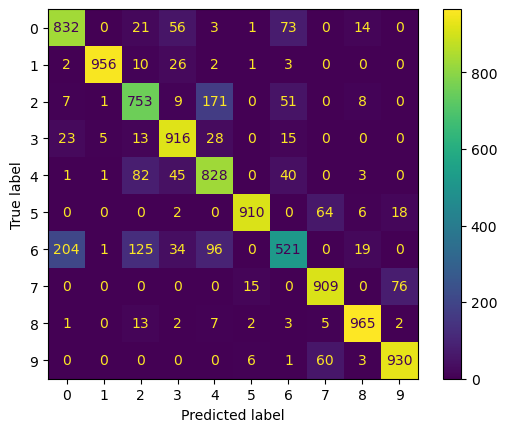

In [14]:
y_hat = model.predict(X_test)
metrics = eval_metrics(y_test, y_hat)
create_confusion_matrix_plot(model, X_test, y_test, "temp\confusion_matrix.png")
artifacts = {
    "confusion_matrix": "temp\confusion_matrix.png"
}
model_signature = infer_signature(X_test, y_hat)
create_mlflow_runs(run_name, params, metrics, artifacts, model, "random forest", model_signature)
print(metrics)

In [15]:
run_name = "RF2"
params = {
    "model_name": "RandomForest",
    "n_estimators": 101,
    "max_depth": 10
}
model = train(params)

c:\Users\SGU\Miniconda3\envs\part_segmentation_mmdetection\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\SGU\Miniconda3\envs\part_segmentation_mmdetection\lib\site-packages\mlflow\models\signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever th

{'precision': 0.8528340118069556, 'recall': 0.8532, 'f1': 0.8506848837541453}


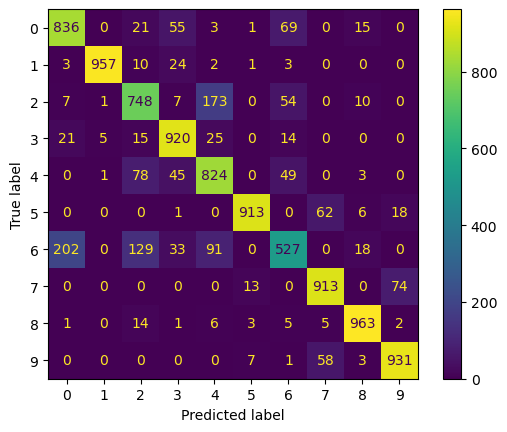

In [16]:
y_hat = model.predict(X_test)
metrics = eval_metrics(y_test, y_hat)
create_confusion_matrix_plot(model, X_test, y_test, "temp\confusion_matrix.png")
artifacts = {
    "confusion_matrix": "temp\confusion_matrix.png"
}
model_signature = infer_signature(X_test, y_hat)
create_mlflow_runs(run_name, params, metrics, artifacts, model, "random forest", model_signature)
print(metrics)

In [17]:
run_name = "MLP1"
params = {
    "model_name": "MLP",
    "epoch": 10,
    "alpha": 0.99,
    "learning_rate": "constant",
    "optimizer": "adam",
    "batch_size": 25
}
model = train(params)


Iteration 1, loss = 2.44128175
Iteration 2, loss = 1.80478486
Iteration 3, loss = 1.27371536
Iteration 4, loss = 1.02384277
Iteration 5, loss = 0.93914865
Iteration 6, loss = 0.85641574
Iteration 7, loss = 0.78888080
Iteration 8, loss = 0.77931276
Iteration 9, loss = 0.77788309
Iteration 10, loss = 0.76070670


c:\Users\SGU\Miniconda3\envs\part_segmentation_mmdetection\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\Users\SGU\Miniconda3\envs\part_segmentation_mmdetection\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\SGU\Miniconda3\envs\part_segmentation_mmdetection\lib\site-packages\mlflow\models\signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever th

{'precision': 0.7747699920023132, 'recall': 0.7791, 'f1': 0.7750196398011369}


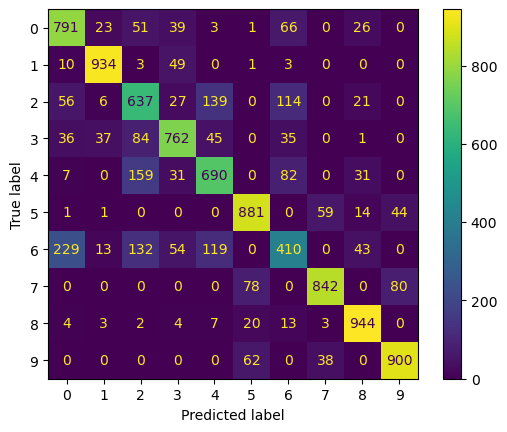

In [18]:
y_hat = model.predict(X_test)
metrics = eval_metrics(y_test, y_hat)
create_confusion_matrix_plot(model, X_test, y_test, "temp\confusion_matrix.png")
artifacts = {
    "confusion_matrix": "temp\confusion_matrix.png"
}
model_signature = infer_signature(X_test, y_hat)
create_mlflow_runs(run_name, params, metrics, artifacts, model, "MLP", model_signature)
print(metrics)

Experiment with pytorch model

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

c:\Users\SGU\Miniconda3\envs\part_segmentation_mmdetection\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [21]:

train_csv = pd.read_csv(r"data/fashion-mnist_train.csv")
test_csv = pd.read_csv(r"data/fashion-mnist_test.csv")

# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_csv.iloc[:10000], transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [22]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [23]:
model = FashionCNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [24]:
num_epochs = 2
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
        
        if not (count % 50):
            print("Iteration: {}, Loss: {}%".format(count, loss.data))

c:\Users\SGU\Miniconda3\envs\part_segmentation_mmdetection\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 50, Loss: 0.5298301577568054%
Iteration: 100, Loss: 0.42931056022644043%
Iteration: 150, Loss: 0.34889891743659973%
Iteration: 200, Loss: 0.2984393239021301%


In [27]:
exp_name = "fashion-mnist"
run_name = "CNN2"
params = {
    "model_name": "CNN3",
    "lr": 0.001,
    "batch_size": 100
}

with mlflow.start_run(run_name=run_name):
    
    label_list = []
    pred_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            test = Variable(images)
            outputs = model(test)
            predicted = torch.max(outputs, 1)[1]
            label_list.extend(labels)
            pred_list.extend(predicted.numpy())
    metrics = eval_metrics(label_list, pred_list)
    print(metrics)
    
    model_signature = infer_signature(test.numpy(), outputs.numpy())
     
    # log params
    mlflow.log_params(params)
    
    # log metrics
    mlflow.log_metrics(metrics)
   
    # log model
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":
        # Register the model
        mlflow.pytorch.log_model(
            model, "model", registered_model_name=params["model_name"])
    else:
        # just log the model for tracking
        mlflow.pytorch.log_model(model, "cnn_model", signature=model_signature)

c:\Users\SGU\Miniconda3\envs\part_segmentation_mmdetection\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


{'precision': 0.874780171508915, 'recall': 0.8693, 'f1': 0.8673661880505624}


Successfully registered model 'CNN3'.
2023/09/01 12:17:06 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CNN3, version 1
Created version '1' of model 'CNN3'.
